<a href="https://colab.research.google.com/github/Wathsu4/SE6108_Project/blob/main/TestCase_Genarator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install coverage mutmut pytest pytest-cov matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.0/688.0 kB 23.0 MB/s eta 0:00:00


In [2]:
import json
import time
import requests
import subprocess
import coverage
import matplotlib.pyplot as plt

In [ ]:
import os

# Prompt user for API key securely
os.environ["GEMINI_API_KEY"] = input("Enter your Gemini API key: ")

API_KEY = os.getenv("GEMINI_API_KEY")
GEN_URL = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?key={API_KEY}"


In [14]:
!git clone https://github.com/Wathsu4/SE6108_Project.git
%cd SE6108_Project

Cloning into 'SE6108_Project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/SE6108_Project


In [4]:
def generate_tests_with_gemini_http(prompt, code, test_type):
    full_prompt = f"""You are given a Python function. Generate {test_type} test cases for it.

Function:
{code}

Only return the Python test cases with no explanation.
"""

    headers = {"Content-Type": "application/json"}
    payload = {
        "contents": [
            {
                "parts": [{"text": full_prompt}]
            }
        ]
    }

    response = requests.post(GEN_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()["candidates"][0]["content"]["parts"][0]["text"]
    else:
        print("Gemini API Error:", response.text)
        return ""


In [5]:
with open("/content/sanitized-mbpp.json", "r") as f:
    dataset = json.load(f)

In [6]:
import time
import subprocess
import sys
import json

# --------------------
def is_syntax_correct(code_str):
    try:
        compile(code_str, "<string>", "exec")
        return True
    except Exception as e:
        print("Syntax error:", e)
        return False

# --------------------
def fix_code_with_gemini_api(code_str):
    """
    Placeholder for Gemini API call to fix syntax errors in code_str.
    Replace with your actual Gemini HTTP request and response parsing.
    """
    print("Calling Gemini API to fix syntax errors...")

    return code_str


def save_split_files(code_str, test_str):

    test_str = test_str.replace("```python", "").replace("```", "").strip()


    with open("main_code.py", "w") as f:
        f.write(code_str.strip() + "\n")


    needs_unittest = "unittest" in test_str


    lines = test_str.splitlines()
    cleaned_lines = []
    for line in lines:
        stripped = line.strip()
        if stripped.startswith("import ") or stripped.startswith("from "):
            continue
        cleaned_lines.append(line)

    test_body = "\n".join(cleaned_lines)


    imports = "import pytest\nfrom main_code import *\n"
    if needs_unittest:
        imports = "import unittest\nfrom main_code import *\n"

    test_code = f"{imports}\n\n{test_body}\n"

    with open("test_code.py", "w") as f:
        f.write(test_code)


def run_coverage_and_get_results():
    import subprocess
    import sys

    # Coverage and capture output
    result = subprocess.run(
        [sys.executable, "-m", "pytest", "test_code.py", "--tb=short", "--maxfail=20"],
        capture_output=True,
        text=True
    )

    output = result.stdout

    # Passed and failed tests
    passed = failed = 0
    for line in output.splitlines():
        if line.strip().startswith("==") and "passed" in line:
            # E.g., "== 3 passed, 1 failed in 0.03s =="
            if "passed" in line:
                passed = int(line.split("passed")[0].split()[-1])
            if "failed" in line:
                failed = int(line.split("failed")[0].split()[-1])
            break

    # Coverage report
    subprocess.run([sys.executable, "-m", "coverage", "run", "--source=main_code", "-m", "pytest", "test_code.py"])
    cov_result = subprocess.run(["coverage", "report"], capture_output=True, text=True)

    coverage_percent = 0
    for line in cov_result.stdout.splitlines():
        if "main_code" in line:
            try:
                coverage_percent = float(line.split()[-1].replace("%", ""))
            except:
                coverage_percent = 0
    return coverage_percent, passed, failed


def simulate_human_effort(num_tests):
    """
    Approximate human time (in seconds) to manually write 'num_tests' test assertions.
    """
    avg_time_per_test_sec = 120
    return num_tests * avg_time_per_test_sec



In [7]:
coverage_list = []
mutation_score_list = []
syntax_correctness_list = []
human_effort_saved = []
gen_times = []
human_effort_estimated = []
pass_counts = []
fail_counts = []


num_samples = min(100, len(dataset))
test_type = "negative"



for idx in range(num_samples):
    sample = dataset[idx]
    prompt = sample["prompt"]
    code = sample["code"]

    print(f"\n=== Sample {idx + 1} ===")
    print("Prompt:", prompt)
    print("------------------------------------------------------------------")

    start_gen = time.time()
    test_code = generate_tests_with_gemini_http(prompt, code, test_type)
    gen_time = time.time() - start_gen



    syntax_ok = is_syntax_correct(test_code)
    if not syntax_ok:
        test_code_fixed = fix_code_with_gemini_api(test_code)
        if is_syntax_correct(test_code_fixed):
            print("Gemini fixed the syntax errors.")
            test_code = test_code_fixed
            syntax_ok = True
        else:
            print("Gemini fix did not correct syntax errors. Proceeding with original test code.")

    print("Syntax Correct:", syntax_ok)


    save_split_files(code, test_code)


    try:
        coverage_percent, passed, failed = run_coverage_and_get_results()
    except Exception as e:
        print("Coverage run error:", e)
        coverage_percent = 0
        passed = failed = 0
    print(f"Coverage: {coverage_percent:.2f}% | Passed: {passed}, Failed: {failed}")


    mutation_score = 0


    test_count = test_code.count("assert") + test_code.count("==")
    human_time = simulate_human_effort(test_count)
    effort_saved = max(human_time - gen_time, 0)
    gen_times.append(gen_time)
    human_effort_estimated.append(human_time)
    print(f"Human Effort Saved: {effort_saved:.2f}s")





    pass_counts.append(passed)
    fail_counts.append(failed)
    coverage_list.append(coverage_percent)
    mutation_score_list.append(mutation_score)
    syntax_correctness_list.append(int(syntax_ok))
    human_effort_saved.append(effort_saved)



=== Sample 1 ===
Prompt: Write a function to find the shared elements from the given two lists.
------------------------------------------------------------------
Syntax error: invalid syntax (<string>, line 1)
Calling Gemini API to fix syntax errors...
Syntax error: invalid syntax (<string>, line 1)
Gemini fix did not correct syntax errors. Proceeding with original test code.
Syntax Correct: False
Coverage: 33.00% | Passed: 0, Failed: 0
Human Effort Saved: 0.00s

=== Sample 2 ===
Prompt: Write a python function to identify non-prime numbers.
------------------------------------------------------------------
Syntax error: invalid syntax (<string>, line 1)
Calling Gemini API to fix syntax errors...
Syntax error: invalid syntax (<string>, line 1)
Gemini fix did not correct syntax errors. Proceeding with original test code.
Syntax Correct: False
Coverage: 29.00% | Passed: 0, Failed: 0
Human Effort Saved: 0.00s

=== Sample 3 ===
Prompt: Write a function to find the n largest integers from

In [8]:
import numpy as np

total_passed = sum(pass_counts)
total_failed = sum(fail_counts)
total_tests = total_passed + total_failed
pass_rate = (total_passed / total_tests) * 100 if total_tests else 0
avg_coverage = np.mean(coverage_list)
total_human_time = np.sum(human_effort_estimated)
total_llm_time = np.sum(gen_times)

print("\n=== Test Summary ===")
print(f"Total Tests Run: {total_tests}")
print(f"✔️ Passed: {total_passed}")
print(f"❌ Failed: {total_failed}")
print(f"📈 Pass Rate: {pass_rate}%" if total_tests else "No tests run.")
print(f"📶  Total Coverage: {avg_coverage} ")
print(f"👤 Total Human Time: {total_human_time}s")
print(f"🤖 Total LLM Time: {total_llm_time}s")
print(f"⌛️ Total Time Saved: {total_human_time - total_llm_time}s")


=== Test Summary ===
Total Tests Run: 149
✔️ Passed: 113
❌ Failed: 36
📈 Pass Rate: 75.83892617449665%
📶  Total Coverage: 38.5 
👤 Total Human Time: 20160s
🤖 Total LLM Time: 161.88905787467957s
⌛️ Total Time Saved: 19998.11094212532s


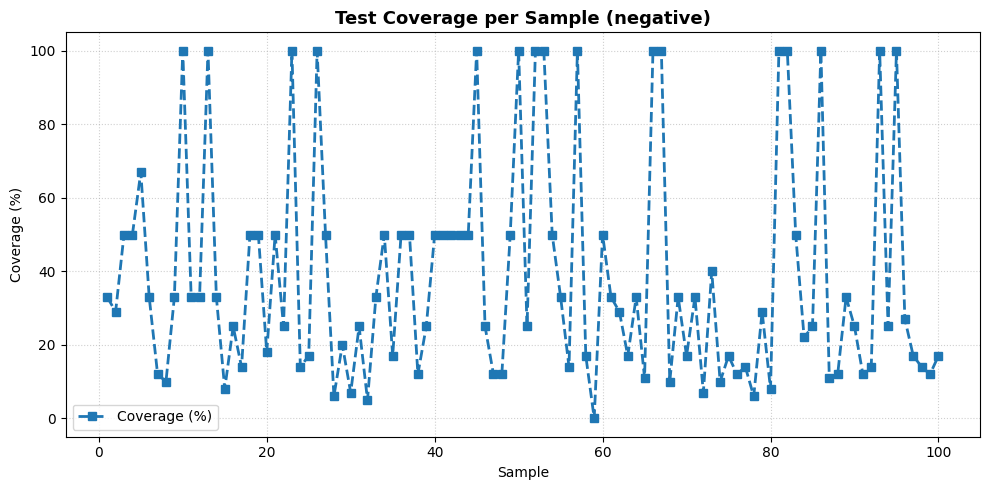

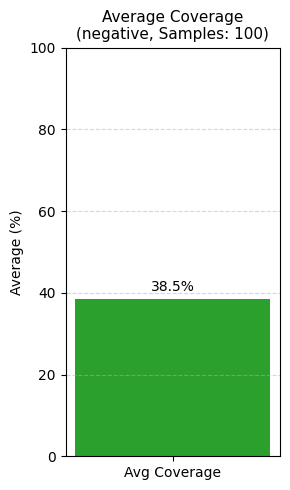

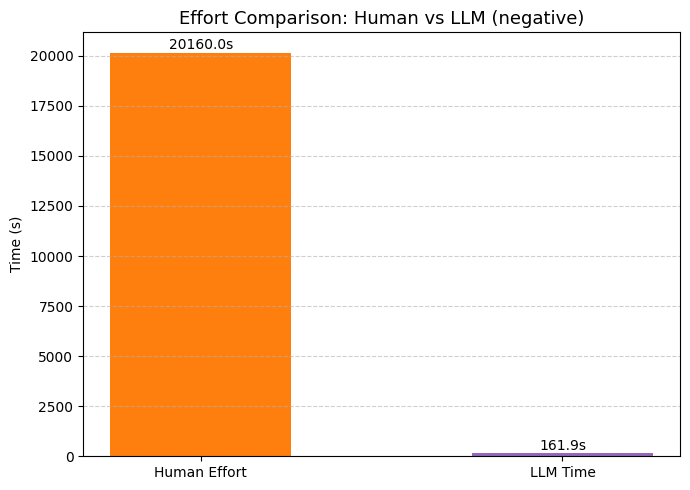

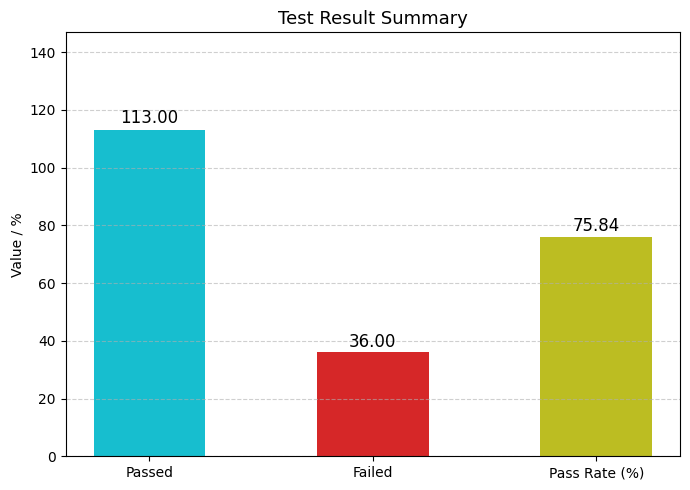

In [9]:
import matplotlib.pyplot as plt

samples = list(range(1, len(coverage_list) + 1))
sample_size = len(coverage_list)

# --- Chart 1: Test Coverage per Sample (Line Plot) ---
plt.figure(figsize=(10, 5))
plt.plot(samples, coverage_list, marker='s', linestyle='--', linewidth=2, color='#1f77b4', label="Coverage (%)")
plt.title(f"Test Coverage per Sample ({test_type})", fontsize=13, fontweight='bold')
plt.xlabel("Sample")
plt.ylabel("Coverage (%)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Chart 2: Average Coverage (Bar Plot) ---
plt.figure(figsize=(3, 5))
plt.bar(["Avg Coverage"], [avg_coverage], width=0.3, color=["#2ca02c"])
plt.title(f"Average Coverage\n({test_type}, Samples: {sample_size})", fontsize=11)
plt.ylabel("Average (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.text(0, avg_coverage + 2, f"{avg_coverage:.1f}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# --- Chart 3: Human Time vs LLM Time ---
plt.figure(figsize=(7, 5))
bar_labels = ["Human Effort", "LLM Time"]
bar_values = [total_human_time, total_llm_time]
colors = ["#ff7f0e", "#9467bd"]
plt.bar(bar_labels, bar_values, width=0.5, color=colors)
plt.title(f"Effort Comparison: Human vs LLM ({test_type})", fontsize=13)
plt.ylabel("Time (s)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, value in enumerate(bar_values):
    plt.text(i, value + 5, f"{value:.1f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# --- Chart 4: Summary of Test Results ---
labels = ["Passed", "Failed", "Pass Rate (%)"]
values = [total_passed, total_failed, pass_rate]
colors = ["#17becf", "#d62728", "#bcbd22"]

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors, width=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.01,
             f'{height:.2f}' if isinstance(height, float) else f'{int(height)}',
             ha='center', va='bottom', fontsize=12)
plt.title("Test Result Summary", fontsize=13)
plt.ylabel("Value / %")
plt.ylim(0, max(values) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


<ipython-input-10-322cbac49538>:24: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


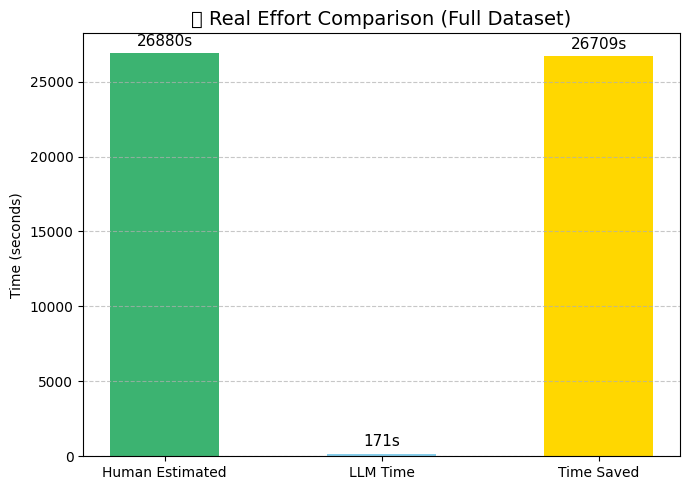

In [10]:
import matplotlib.pyplot as plt

# Real summary data
real_human_time = 26880  # in seconds
real_llm_time = 171.15   # in seconds
time_saved = real_human_time - real_llm_time

# Bar chart
plt.figure(figsize=(7, 5))

bar_labels = ["Human Estimated", "LLM Time", "Time Saved"]
bar_values = [real_human_time, real_llm_time, time_saved]
bar_colors = ["mediumseagreen", "skyblue", "gold"]

plt.bar(bar_labels, bar_values, width=0.5, color=bar_colors)
plt.title("🕒 Real Effort Comparison (Full Dataset)", fontsize=14)
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values on bars
for i, value in enumerate(bar_values):
    plt.text(i, value + 300, f"{value:.0f}s", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [16]:
!echo ".ipynb_checkpoints/" >> .gitignore
!echo "*.env" >> .gitignore
!echo "secrets.txt" >> .gitignore
